<center>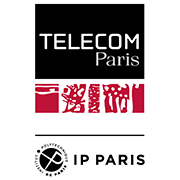</center>

<h1><center><strong><font color='crimson'>
  IA717: POETRY GENERATION PROJECT
</font></strong></center></h1>

<center>
  <h3> Project Supervisor <br/> Cyril Chhun</h3>
  <email>cyril.chhun@telecom-paris.fr</email>
  <br/>
  Year 2021-2022
</center>

<h3><center><font color='cornflowerblue'><strong>
    Student Version  
</strong></font></center></h3>

<student><center>

  Ramzi Khalifa
  <br/>Louis-Gabriel Pouillot
  <br/>Yann Rodriguez
</student></center>

---
# <center><font color="crimson">__PART 3: GENERATE__

---
# <font color="crimson">__SETUP__</font>

## __Install__

### Modules for Plint

This modules are necessary for evalution measures

In [ ]:
%pip install plint==0.1
%pip install haspirater
%pip install frhyme
%pip install language-tool-python

## __Packages__

In [ ]:
from plint import verse, template
import plint.pattern
import torch.nn as nn
import pandas as pd
import numpy as np
import torch
import os
import re
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import language_tool_python
tool = language_tool_python.LanguageTool('fr')

## __Mount drive google & setup cuda/cpu device__

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE = str(device)
print(f'\n Device used (cuda/cpu):\t{device}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

 Device used (cuda/cpu):	cuda


## __Paths__

In [ ]:
if IN_COLAB:
    ROOT_PATH = '/content/drive/MyDrive/Colab Notebooks/IA717_NLP_Poem_project/'
else:
    ROOT_PATH=''
    
CHECKPOINT_PATH = ROOT_PATH+'dramacode_checkpoints/'
CORPUS_DIR = ROOT_PATH+'dramacode_corpus/'

POEMS_DIR = ROOT_PATH+'POEMS_H1/'

CORPUS_PREFIX=''

---
# <font color="crimson">__LSTM MODEL__</font>

## __Model definition__

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, ntoken, ninp, nhid, nlayers, dropout=0.2, initrange=0.1):
        """
            ntoken: length of the dictionary,
            ninp: dimension of the input,
            nhid: dimension of the hidden layers,
            nlayers: number of layers,
            dropout: regularization parameter
            initrange: range for weight initialization
        """
        super().__init__()
        self.ntoken = ntoken
        self.nhid = nhid
        self.nlayers = nlayers
        self.initrange = initrange

        ## Modified
        # Create a dropout object to use on layers for regularization
        self.drop = nn.Dropout(p=dropout)

        # Create an encoder - which is an embedding layer
        self.encoder = nn.Embedding(ntoken, ninp)

        # Create the LSTM layers - find out how to stack them !
        self.rnn =  nn.LSTM(ninp, nhid, nlayers, dropout=dropout)

        # Create what we call the decoder: a linear transformation to map the hidden state into scores for all words in the vocabulary
        # (Note that the softmax application function will be applied out of the model)
        self.decoder = nn.Linear(nhid,ntoken)
        ##

        # Initialize non-recurrent weights 
        self.init_weights()

    ## Modified
    def init_weights(self):
        """
            Initialize the encoder and decoder weights with the uniform distribution,
            between -initrange and +initrange, and the decoder bias with zeros
        """
        nn.init.uniform_(self.encoder.weight,-self.initrange,+self.initrange)
        nn.init.uniform_(self.decoder.weight,-self.initrange,+self.initrange)
        nn.init.zeros_(self.decoder.bias)
    ##

    def init_hidden(self, bsz):
        weight = next(self.parameters())
        return (weight.new_zeros(self.nlayers, bsz, self.nhid),
                weight.new_zeros(self.nlayers, bsz, self.nhid))


    ## Modified
    def forward(self, input, hidden1):
        
        # Process the input with the encoder, then dropout
        emb = self.encoder(input) # EMBEDING
        emb = self.drop(emb) 

        # Apply the LSTMs
        output, hidden2 = self.rnn(emb,hidden1)
        output = self.drop(output)
        
        # Decode into scores
        decoded = self.decoder(output)
        return decoded, hidden2
    ##

## __Corpus class__

In [ ]:
class Dictionary(object):
    def __init__(self):
        self.word2idx = {}  # if word2idx["hello"] == 42 ...
        self.idx2word = []  # ... then idx2word[42] == "hello" 

    def add_word(self, word):
        """ 
          This function should check if the word is in word2idx; if it
          is not, it should add it with the first available index
        """
        pos = self.__len__()

        p = self.word2idx.get(word, pos)
        if p == pos:
          self.word2idx[word]=p
          self.idx2word.append(word)
        return p

    def __len__(self):
        return len(self.idx2word)

In [ ]:
class Corpus(object):
    def __init__(self, path):

        self.dictionary = Dictionary()
        self.eos_token = '<eos>' # end of sentence (line) token
        self.eos_id = self.dictionary.add_word('<eos>')

        self.train = self.tokenize(path+CORPUS_PREFIX+'train.txt')
        self.valid = self.tokenize(path+CORPUS_PREFIX+'valid.txt')
        self.test = self.tokenize(path+CORPUS_PREFIX+'test.txt')
        print(path+CORPUS_PREFIX+'train.txt')

    def tokenize(self, path):
        """
            Tokenizes a text file, knowing the dictionary, in order to 
            tranform it into a list of indices.
            The str.split() function might be useful.
        """
        assert os.path.exists(path)

        ids = []
        with open(path,'r') as f:
          for line in f:
            tokens = line.split()
        
            line_ids = [self.dictionary.add_word(token) for token in tokens]

            ids.extend(line_ids)
            ids.append(self.eos_id)

        return torch.tensor(ids,dtype=torch.int64)
    
    def to_words(self, tensor):
        return ' '.join([self.dictionary.idx2word[int(val)] for val in tensor])

## __Init model with hyper parameters__

In parameter.csv the models trained are declared. 

Models are located in CHECKPOINT_PATH directory

The corpus_prefix corresponds to the type of corpus the model was built with: standard, plint, normalized and normalized with plint

In [ ]:
param = pd.read_csv(CHECKPOINT_PATH+'parameter.csv', na_filter="", decimal='.')
param


,model_name,corpus_prefix,corpus_name,embedding_size,hidden_size,n_layers,dropout
0,model_cuda_20220126_234211_KEEP.pt,2601_,2601_corpus.txt,512,1024,2,0.35
1,H_1_model_cuda_20220204_094757.pt,,corpus.txt,512,1024,2,0.35
2,DEFAULT_model_cuda_20220204_145158.pt,,corpus.txt,512,1024,2,0.20
3,P_DEFAULT_model_cuda_20220205_065101,plint_,plint_corpus.txt,512,1024,2,0.20
4,N_DEFAULT_normalized_model_cuda_20220204_18431...,normalized_,normalized_corpus.txt,512,1024,2,0.20
5,H_1_P_model_cuda_20220205_115941.pt,plint_,plint_corpus.txt,512,1024,2,0.35
6,H_2_model_cuda_20220205_171043.pt,,corpus.txt,512,1024,3,0.10
7,H_1_N_normalized_model_cuda_20220205_125508.pt,normalized_,normalized_corpus.txt,512,1024,2,0.35
8,H_1_PN_normalized_model_cuda_20220205_142734.pt,plint_normalized_,plint_normalized_corpus.txt,512,1024,2,0.35


The variable `index_model` below corresponds to the index in the table loaded from *parameter.csv* in the previous cell.

In [ ]:
# load model from parameter.csv
index_model = 1

model_path = CHECKPOINT_PATH + param.model_name[index_model]
CORPUS_PREFIX= param.corpus_prefix[index_model]

print("Loading corpus ", end='')
corpus = Corpus(CORPUS_DIR)

n_tokens = corpus.dictionary.__len__()
embedding_size = int(param.embedding_size[index_model])
hidden_size = int(param.hidden_size[index_model])
n_layers = int(param.n_layers[index_model])
dropout = float(param.dropout[index_model])

# EVAL_BATCH_SIZE = 16
# SEQ_LEN = 30
# SEED = 567
# torch.manual_seed(SEED)

#init
model =  LSTMModel(n_tokens, embedding_size, hidden_size, n_layers, dropout=dropout).to(device)
print("Done")

Loading corpus /content/drive/MyDrive/Colab Notebooks/IA717_NLP_Poem_project/dramacode_corpus/train.txt
Done


## __Load the model__

In [ ]:
if os.path.exists(model_path):
  with open(model_path, 'rb') as f:
      if device==torch.device('cpu'):
        model = torch.load(f, map_location='cpu')
      else:
        model = torch.load(f)
      model.rnn.flatten_parameters()
  print(f"Model {model_path.split('/')[-1]} loaded")
else:
  print(f"/!\ MISSING {model_path.split('/')[-1]}")

Model H_1_model_cuda_20220204_094757.pt loaded


---
# <font color="crimson">__CORE GENERATION FUNCTIONS__

## __Sampling__

In [ ]:
def sample_argmax(pb_output):
    return (torch.argmax(pb_output), [])
  

def sample_top_k(pb_output,k,keep_distrib=False):

    top_k = torch.topk(torch.squeeze(pb_output),k)
    
    if keep_distrib:
        distrib = top_k.values.cpu().detach().numpy()
        choice = torch.tensor(np.random.choice(top_k.indices.cpu(),1,p=distrib/np.sum(distrib)))
    else:
        choice = torch.tensor(np.random.choice(top_k.indices.cpu(),1))
    
    idx_p = [(top_k.indices[i],top_k.values[i]) for i in range(k)]

    return choice, idx_p


def sample_top_p(pb_output,pmax,keep_distrib=False):
 
    sorted, indices = torch.sort(torch.squeeze(pb_output),descending=True)
    idx=[]; p=[]; i=0; 
    
    while sum(p)<pmax:
        idx.append(indices[i].cpu())
        p.append(sorted[i].cpu().detach().numpy())
        i+=1
    
    if keep_distrib:
        choice = torch.tensor(np.random.choice(idx,1,p=p/sum(p)))
    else:
        choice = torch.tensor(np.random.choice(idx,1))

    idx_p = [(indices[idx], sorted[idx]) for idx in range(i)]

    return choice, idx_p


def sample_beam_n_step(pb_output,model,hidden,device,temperature,softmax,pmax=0.5): 
    """
    other ways :
        - possibility to add beam_length to go deeper than 2
        - we move forward one step at a time : possibility to go 2 by 2 (or n by n ref. to the point above)
            /!\ then need to change the step of the loop..
    """
    #select only top_p to be faster
    sorted, indices = torch.sort(torch.squeeze(pb_output),descending=True)
    words_idx_prob=[]; i=0; p_tot=0
    
    while p_tot<pmax:
        words_idx_prob.append([indices[i],sorted[i]])
        p_tot+=sorted[i]
        i+=1

    #beam part
    outputs = []
    for id,prob in words_idx_prob:
        ix = torch.tensor([[id]]).to(device)
        output, _ = model(ix, hidden)
        outputs.append(torch.squeeze(softmax((output/temperature)[0]))*prob)
    outputs = torch.stack(outputs)

    word1_idx, word2_idx = np.unravel_index(torch.argmax(outputs.cpu()), outputs.cpu().shape)
    return (word1_idx, [])

In [ ]:
def display_selected_words(int_to_vocab, best_idx, selected_idxs):
    """
    Display the potential word and its probability
    """
    if len(selected_idxs) > 0:
      print('_'*48, '\n/'+' '*46+'\\',
            f'\nword:  \"{int_to_vocab[best_idx]}\"',
            '-'*48)
            
      for i in range(len(selected_idxs)):
        print(int_to_vocab[selected_idxs[i][0]], ":", round( float(selected_idxs[i][1]) , 6) )
      print("\\"+"_"*46+"/")

## __Generate__

In [ ]:
def generate(source, n_words, sampling={'kind':'argmax','value':None,'keep_distrib':None}, temperature=1, display_words=True):
    """
        n_words: number of words to generate
        fout: optional output file
    """
    vocab_to_int = corpus.dictionary.word2idx
    int_to_vocab = corpus.dictionary.idx2word
    model.eval()
    softmax = nn.Softmax(dim=-1)
    source = source.split()
    hidden = model.init_hidden(1)
    for v in hidden:
        v = v.to(device)
    for w in source:
        ix = torch.tensor([[vocab_to_int[w]]]).to(device)
        output, hidden = model(ix, hidden)
    output = output / temperature
    
    if sampling['kind']=='argmax':
        sampler = lambda x: sample_argmax(x)
    elif sampling['kind']=='top_k':
        sampler = lambda x: sample_top_k(x,sampling['value'],keep_distrib=sampling['keep_distrib'])
    elif sampling['kind']=='top_p':
        sampler = lambda x: sample_top_p(x,sampling['value'],keep_distrib=sampling['keep_distrib'])
    elif sampling['kind']=='beam':
        sampler = lambda x: sample_beam_n_step(x,model,hidden,device,temperature,softmax,pmax=sampling['value'])

    (best_idx, selected_idxs) = sampler(softmax(output[0]))
    if display_words: display_selected_words(int_to_vocab, best_idx, selected_idxs)

    words = []
    words.append(int_to_vocab[best_idx])
    
    for _ in range(0, n_words):
        ix = torch.tensor([[best_idx]]).to(device)
        output, hidden = model(ix, hidden)
        output = output / temperature
        (best_idx, selected_idxs) = sampler(softmax(output[0]))
        words.append(int_to_vocab[best_idx])
        if display_words: display_selected_words(int_to_vocab, best_idx, selected_idxs)
     
    text = ' '.join(words)
    text = text.replace('<eos>', '\n')
    return words

## __Post Processing__

In [ ]:
def upper_match(m):
  return m.group(1) + ' ' +  m.group(2).upper()
  

def post_processing(words):
  poem = ''.join([f"{word.strip()} " for word in words]).replace('<eos> ', '\n')
  
  # remove last line if not complete
  if poem[-1] != '\n':
    lines = poem.split('\n')
    lines.pop()
  else:
    lines = poem.split('\n')

  pp_lines=[]
  for line in lines:
    line = re.sub(' _', r' ', line)
    line = re.sub('oe', r'œ', line)
    # coller certaines punct au mot d'avant
    line = re.sub(' ([\.,])', r'\1', line)

    # upcase letter after some puncts
    line = re.sub('([\.!\?]) ([\w])', upper_match, line)

    # upcase first letter
    if len(line) > 2:
      line = line[0].upper()+line[1:]
    elif len(line) == 1:
        line = line[0].upper()

    # line = line[1:]
    pp_lines.append(line+'\n')

  output = ''.join(pp_lines)
  output = re.sub('[\n]{2,}', r'\n', output)
  return output

## __Evaluate__

### _Alexandrines checker_

TODO

In [ ]:
def check_alexandrines(verses,log=False):
    size = 12
    nb_alex = 0
    for i,ver in enumerate(verses):
        v = verse.Verse(ver, template.Template(), plint.pattern.Pattern(str(size)))
        v.parse()
        nb_alex += 1*v.valid()
        if log*(not v.valid()): print('Invalid verse: ',ver)
        if (i%5000==0)*(i!=0): print(f'processing verse {i//1000}k/{len(verses)//1000}k ...')
    
    return nb_alex, len(verses)

## __REPORT RESULTS__

In [ ]:
def report_output(output, to_file=None, to_extension='_default.txt', prefix=None):
  
  if to_file != None:
    fname = f'{to_file}{to_extension}'
    path = os.path.join(CHECKPOINT_PATH, fname)
    
    with open(path, 'a') as f:
      if prefix:
        f.write('-'*len(prefix)+'\n'+prefix+'\n'+'-'*len(prefix)+'\n')
      f.write(output+'\n')
  else:
    print('\nWarning: Loss not saved to file')

---
# <font color="crimson">__GENERATION BENCHMARK__

In [ ]:
import gc
def clean_memory():
  gc.collect()
  torch.cuda.empty_cache()

clean_memory()

In [ ]:
def join_words(words):
  poem = ''.join([f"{word.strip()} " for word in words]).replace('<eos> ', '\n')
  
  # remove last line if not complete
  if poem[-1] != '\n':
    lines = poem.split('\n')
    lines.pop()
  else:
    lines = poem.split('\n')
  pp_lines = []
  for line in lines:
    # line = line[1:]
    pp_lines.append(line+'\n')

  return ''.join(pp_lines)

## Génération de poèmes

Les poèmes sont enregistrés dans le répertoire CHECKPOINT_PATH dans un fichier portant le nom du modèle suivi de l'extension _poem.txt

Si le nombre de mots est important comment les lignes print(poem_*)

La méthode beam nécessite trop de ressources, le cas échéant commenter les lignes correspondantes.

Vous pouvez choisir par les différentes sources proposées.

In [ ]:
EXTENSION_POEMS = '_poems.txt'
path = param.model_name[index_model].split('.')[0]

ressources_used = f"Model  used : {param.model_name[index_model]} \nCorpus used : {param.corpus_name[index_model]}\n"
print(ressources_used)
report_output(ressources_used, to_file=path, to_extension=EXTENSION_POEMS, prefix='using pattern as source:')

poem_file = os.path.join(CHECKPOINT_PATH, path, EXTENSION_POEMS)
# n_words = 50000
n_words=50
top_k_value=5

top_p_value=0.5

top_beam_value=0.2
temperature=1

if os.path.exists(model_path):

    # source = 'l\'homme bleu qui <eos>'
    # source = "clymène je t'aime"
    # source = "tout m' afflige et me nuit et conspire à me nuire <eos>" # Phère, Racine
    # source = "nous partîmes cinq cents ; mais par un prompt renfort <eos> nous nous vîmes trois mille en arrivant au port <eos>" # Le Cid, Corneille
    # source = "a force de sagesse , on peut être blâmable . <eos>" #Le misanthrope, Molière
    source = "<eos> on ne m' abuse point par des promesses vaines <eos> tant qu' un reste de sang coulera dans mes veines <eos>" #Iphigénie, Racine
    # source = "seigneur ; ma folle ardeur malgré moi se déclare <eos>" # Phèdre, Racine
    # source = "<eos> qui connaît son sourire a connu le parfait . <eos> elle fait de la grâce avec rien , elle fait <eos> tenir tout le divin dans un geste quel conque <eos>" #Cyrano de Bergerac, Edmond Rostand
    # source = "<eos> pendant que d' une main il s' attache à la vôtre <eos> ne voit-il pas la mort qui l' épouse de l' autre <eos>" # Hernani, Victor Hugo
    # source = "<eos> ô rage ! ô désespoir ! ô viellesse ennemie ! <eos> n' ai-je donc tant vécu que pour cette infamie ? <eos>" # Le Cid, Corneille
    
    report_output(source, to_file=path, to_extension=EXTENSION_POEMS, prefix='using pattern as source:')
    print(f'\tSOURCE\n{source}')

    print('\n\tWITH ARGMAX')
    words = generate(source, n_words=n_words, sampling={'kind':'argmax'} , temperature=1)
    poem_argmax = post_processing(words)
    print(poem_argmax)
    with open(os.path.join(CHECKPOINT_PATH,"words_poem_argmax_"+EXTENSION_POEMS), 'w') as f_poem:
      f_poem.write(join_words(words))
    with open(os.path.join(CHECKPOINT_PATH,"poem_argmax_"+EXTENSION_POEMS), 'w') as f_poem:
      f_poem.write(poem_argmax)
    report_output(poem_argmax, to_file=path, to_extension=EXTENSION_POEMS, prefix='WITH ARGMAX')
    valid,total = check_alexandrines(poem_argmax.split(' \n'))
    print(f'> valid alexandrines: {valid/total*100:.1f}%')    

    print('\n\tWITH TOP_K')
    words = generate(source, n_words=n_words, sampling={'kind':'top_k','value':top_k_value,'keep_distrib':False} , temperature=1, display_words=False)
    poem_topk = post_processing(words)
    print(poem_topk)
    with open(os.path.join(CHECKPOINT_PATH,"words_poem_topk_"+EXTENSION_POEMS), 'w') as f_poem:
      f_poem.write(join_words(words))
    with open(os.path.join(CHECKPOINT_PATH,"poem_topk_"+EXTENSION_POEMS), 'w') as f_poem:
      f_poem.write(poem_topk)
    report_output(poem_topk, to_file=path, to_extension=EXTENSION_POEMS, prefix='WITH TOP_K')
    valid,total = check_alexandrines(poem_topk.split(' \n'))
    print(f'> valid alexandrines: {valid/total*100:.1f}%')

    print('\n\tWITH TOP_K (keep distrib)')
    words = generate(source, n_words=n_words, sampling={'kind':'top_k','value':top_k_value,'keep_distrib':True} , temperature=1, display_words=False)
    poem_topk_distrib = post_processing(words)
    print(poem_topk_distrib)
    with open(os.path.join(CHECKPOINT_PATH, "words_poem_topk_distrib_"+EXTENSION_POEMS), 'w') as f_poem:
      f_poem.write(join_words(words))
    with open(os.path.join(CHECKPOINT_PATH, "poem_topk_distrib_"+EXTENSION_POEMS), 'w') as f_poem:
      f_poem.write(poem_topk_distrib)
    report_output(poem_topk_distrib, to_file=path, to_extension=EXTENSION_POEMS, prefix='WITH TOP_K (keep distrib)')
    valid,total = check_alexandrines(poem_topk_distrib.split(' \n'))
    print(f'> valid alexandrines: {valid/total*100:.1f}%')

    print('\n\tWITH TOP_P')
    words = generate(source, n_words=n_words, sampling={'kind':'top_p','value':top_p_value,'keep_distrib':False} , temperature=1, display_words=False)
    poem_topp = post_processing(words)
    print(poem_topp)
    with open(os.path.join(CHECKPOINT_PATH, "words_poem_topp_"+EXTENSION_POEMS), 'w') as f_poem:
      f_poem.write(join_words(words))
    with open(os.path.join(CHECKPOINT_PATH, "poem_topp_"+EXTENSION_POEMS), 'w') as f_poem:
      f_poem.write(poem_topp)
    report_output(poem_topp, to_file=path, to_extension=EXTENSION_POEMS, prefix='WITH TOP_P')
    valid,total = check_alexandrines(poem_topp.split(' \n'))
    print(f'> valid alexandrines: {valid/total*100:.1f}%')

    print('\n\tWITH TOP_P (keep distrib)')
    words = generate(source, n_words=n_words, sampling={'kind':'top_p','value':top_p_value,'keep_distrib':True}, temperature=1, display_words=False)
    poem_topp_distrib = post_processing(words)
    print(poem_topp_distrib)
    with open(os.path.join(CHECKPOINT_PATH, "words_poem_topp_distrib_"+EXTENSION_POEMS), 'w') as f_poem:
      f_poem.write(join_words(words))
    with open(os.path.join(CHECKPOINT_PATH, "poem_topp_distrib_"+EXTENSION_POEMS), 'w') as f_poem:
      f_poem.write(poem_topp_distrib)
    report_output(poem_topp_distrib, to_file=path, to_extension=EXTENSION_POEMS, prefix='WITH TOP_P (keep distrib)')
    valid,total = check_alexandrines(poem_topp_distrib.split(' \n'))
    print(f'> valid alexandrines: {valid/total*100:.1f}%')


    print('\n\tWITH BEAM')
    words = generate(source, n_words=n_words, sampling={'kind':'beam','value':top_beam_value} , temperature=temperature, display_words=False)
    poem_beam = post_processing(words)
    print(poem_beam)
    report_output(poem_beam, to_file=path, to_extension=EXTENSION_POEMS, prefix='WITH BEAM')
    valid,total = check_alexandrines(poem_beam.split(' \n'))
    print(f'> valid alexandrines: {valid/total*100:.1f}%')

    print('\n'+'-'*30,
        f'\nModel: {param.model_name[index_model]}',
        '\n'+'-'*30,
        '\nGenerated with following  params\n',
        param.iloc[index_model])

else:
    print(f'MISSING file: {param.model_name[index_model]}')

Model  used : H_1_model_cuda_20220204_094757.pt 
Corpus used : corpus.txt

	SOURCE
<eos> on ne m' abuse point par des promesses vaines <eos> tant qu' un reste de sang coulera dans mes veines <eos>

	WITH ARGMAX
Et je ne puis souffrir que des yeux de mes yeux 
Je ne puis plus souffrir que de mes ennemis. 
Je ne puis plus souffrir que je ne puis comprendre 
Que je ne puis souffrir que je ne puis comprendre. 

> valid alexandrines: 80.0%

	WITH TOP_K
Je me sens de ma main les plaisirs et mes frères. 
Vous êtes donc, monsieur ! Que voulez-vous, je vous vois. Moi, 

> valid alexandrines: 33.3%

	WITH TOP_K (keep distrib)
Un homme qui n'a rien qui puisse me flatter. 
Je ne me trompe point, et je suis satisfait. 
Et si, par mes conseils, je ne suis pas la peine 
Je ne suis pas en toi qui ne soit si coupable. 

> valid alexandrines: 80.0%

	WITH TOP_P
Ces auteurs des ingrats et des maux où je sens 
Mais le grand sang du ciel qui rend la nuit seconde, 
Du crime où je la vis peut causer sa maîtr

" became 
[]
" became 
[]
". became 
[]


In [ ]:
clean_memory()

# <font color="crimson">__EVALUATION__</font>

### _Metrics_

In [ ]:
with open(os.path.join(POEMS_DIR,"poem_argmax__poems.txt"), encoding='utf-8') as f:
    poem_argmax = f.readlines()

with open(os.path.join(POEMS_DIR,"poem_topk__poems.txt"), encoding='utf-8') as f:
    poem_topk = f.readlines()

with open(os.path.join(POEMS_DIR,"poem_topk_distrib__poems.txt"), encoding='utf-8') as f:
    poem_topk_distrib = f.readlines()

with open(os.path.join(POEMS_DIR,"poem_topp__poems.txt"), encoding='utf-8') as f:
    poem_topp = f.readlines()

with open(os.path.join(POEMS_DIR,"poem_topp_distrib__poems.txt"), encoding='utf-8') as f:
    poem_topp_distrib = f.readlines()

In [ ]:
with open(os.path.join(POEMS_DIR,"words_poem_argmax__poems.txt"), encoding='utf-8') as f:
    word_argmax = f.readlines()

with open(os.path.join(POEMS_DIR,"words_poem_topk__poems.txt"), encoding='utf-8') as f:
    word_topk = f.readlines()

with open(os.path.join(POEMS_DIR,"words_poem_topk_distrib__poems.txt"), encoding='utf-8') as f:
    word_topkD = f.readlines()

with open(os.path.join(POEMS_DIR,"words_poem_topp__poems.txt"), encoding='utf-8') as f:
    word_topp = f.readlines()

with open(os.path.join(POEMS_DIR,"words_poem_topp_distrib__poems.txt"), encoding='utf-8') as f:
    word_toppD = f.readlines()

In [ ]:
p = [poem_topk, poem_topk_distrib, poem_topp, poem_topp_distrib]
w = [word_argmax, word_topk, word_topkD, word_topp, word_toppD]
pNames = ['Poem top-K', 'Poem top-K distib', 'Poem top-P', 'Poem top-P distrib']

poems = [''.join(poem) for poem in p]
words = [''.join(word) for word in w]

### _Variety of words_

In [ ]:
for i,pw in enumerate(w):
    print(['Argmax', 'Topk', 'Topk D', 'Topp', 'Topp D'][i], ':')
    print(len(set(' '.join(pw).split())), 'mots')
    print('-'*10)

Argmax :
16 mots
----------
Topk :
705 mots
----------
Topk D :
906 mots
----------
Topp :
2166 mots
----------
Topp D :
1488 mots
----------


### _Spellcheck with LanguageTool_

In [ ]:
matchesP = [tool.check(poem) for poem in poems]

with open(os.path.join(CORPUS_DIR,'corpus_LT.txt'), encoding='utf-8') as f:
    lines = f.readlines()
lines_in_corpus = ''.join(lines)

lines_in_corpus = lines_in_corpus.replace('  ', ' ')
cor = lines_in_corpus[:100_000]
matchesC = tool.check(''.join(cor))

In [ ]:
matchesP = [tool.check(poem) for poem in poems]

with open(os.path.join(CORPUS_DIR,'corpus_LT.txt'), encoding='utf-8') as f:
    lines = f.readlines()
lines_in_corpus = ''.join(lines)

lines_in_corpus = lines_in_corpus.replace('  ', ' ')
cor = lines_in_corpus[:100_000]
matchesC = tool.check(''.join(cor))

In [ ]:
def check2df(matches):
    mRId = [matches[i].ruleId for i in range(len(matches))]
    mCat = [matches[i].category for i in range(len(matches))]
    mCtx = [matches[i].context for i in range(len(matches))]
    mRpl = [matches[i].replacements for i in range(len(matches))]
    
        
    d = {'Rule ID': mRId, 'Category': mCat, 'Context': mCtx, 'Replacements': mRpl}
    df = pd.DataFrame(data=d)
    return df

In [ ]:
dfP = [check2df(match) for match in matchesP]
dfC = check2df(matchesC)

dfP = [dfP[idx].loc[(dfP[idx]['Category'] == 'TYPOS') | (dfP[idx]['Category'] == 'CAT_GRAMMAIRE') | (dfP[idx]['Category'] == 'TYPOGRAPHY') | (dfP[idx]['Category'] == 'AGREEMENT') | (dfP[idx]['Category'] == 'PUNCTUATION')] for idx in range(len(dfP))]
dfC = dfC.loc[(dfC['Category'] == 'TYPOS') | (dfC['Category'] == 'CAT_GRAMMAIRE') | (dfC['Category'] == 'TYPOGRAPHY') | (dfC['Category'] == 'AGREEMENT') | (dfC['Category'] == 'PUNCTUATION')]

In [ ]:
def countMistakes(dfCorpus = dfC, dfPoem = dfP):
    df = []

    for dfp in dfPoem:
        catUniq = np.unique(np.concatenate([dfC['Category'], dfp['Category']]))
        mistakeC = []
        mistakeP = []

        for cat in catUniq:
            mistakeC.append(len(dfCorpus[dfCorpus['Category'] == cat]))
            mistakeP.append(len(dfp[dfp['Category'] == cat]))

        d = {'Mistakes': catUniq, 'Corpus': mistakeC, 'Poem': mistakeP}
        df.append(pd.DataFrame(data=d))
    
    return df

In [ ]:
dfCount = countMistakes()

In [ ]:
threshold = 0.005
thresholdC = []
thresholdP = []
valuesC = []
valuesP = []
namesC = []
namesP = []

for idx, dfCnt in enumerate(dfCount):
    thresholdC.append(dfCnt['Corpus'].values.sum() * threshold)
    thresholdP.append(dfCnt['Poem'].values.sum() * threshold)

    valuesC.append(dfCnt.loc[dfCnt['Corpus'] > thresholdC[idx], 'Corpus'])
    valuesP.append(dfCnt.loc[dfCnt['Poem'] > thresholdP[idx], 'Poem'])

    namesC.append(dfCnt.iloc[valuesC[idx].index]['Mistakes'])
    namesP.append(dfCnt.iloc[valuesP[idx].index]['Mistakes'])

#### Plots

In [ ]:
def plotPie(df = dfCount):

    for idx, dfCnt in enumerate(dfCount):
        fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]])
        fig.add_trace(go.Pie(labels=namesC[idx], values=valuesC[idx], name="Corpus"),
                    1, 1)
        fig.add_trace(go.Pie(labels=namesP[idx], values=valuesP[idx], name="Poem"),
                    1, 2)

        fig.update_traces(hole=.6, hoverinfo="label+percent+name")

        fig.update_layout(
            title_text="Mistakes percentage ",
            annotations=[dict(text='Corpus', x=0.2, y=0.5, font_size=20, showarrow=False),
                        dict(text=pNames[idx], x=0.832, y=0.5, font_size=17, showarrow=False)])
        fig.show()

In [ ]:
def plotBar(df=dfCount):
    alpha = 1e-4
    for idx, dfCnt in enumerate(dfCount):
        fig = go.Figure(data=[
            go.Bar(name='Corpus', x=namesC[idx], y=valuesC[idx] / (dfCnt['Corpus'].values.sum()+alpha) * 100),
            go.Bar(name=pNames[idx], x=namesP[idx], y=valuesP[idx] / (dfCnt['Poem'].values.sum()+alpha) * 100)
        ])
        fig.update_layout(barmode='group', title_text="Mistakes percentage " + pNames[idx])
        fig.show()

In [ ]:
def plotBarRaw(df=dfCount, plotPoem = True):
    alpha = 1e-4
    if plotPoem == True:
        fig = go.Figure(data=[
            go.Bar(name=pNames[0], x=namesP[0], y=valuesP[0]),
            go.Bar(name=pNames[1], x=namesP[1], y=valuesP[1]),
            go.Bar(name=pNames[2], x=namesP[2], y=valuesP[2]),
            go.Bar(name=pNames[3], x=namesP[3], y=valuesP[3])
        ])
        fig.update_layout(barmode='group', title_text="Mistakes percentage " + pNames[idx])
        fig.show()
    else :
        fig = px.bar(dfCount[0], x=namesC[0].values, y=valuesC[0].values)
        fig.update_layout(barmode='group', title_text="Mistakes raw " + 'Corpus')
        fig.show()

In [ ]:
plotPie()

In [ ]:
plotBarRaw(df=dfCount, plotPoem=False)

In [ ]:
plotBarRaw(df=dfCount, plotPoem=True)

In [ ]:
alpha = 1e-3

for idx, poem in enumerate(p):
    print(pNames[idx])
    print("Nombre de fautes dans le poème :", str(len(dfP[idx])) + " /", ''.join(poem).count('\n'), "lignes")
    print("Erreur par ligne : ", str(np.round(len(dfP[idx]) / (''.join(poem).count('\n') + alpha), 2)))
    print('-'*60)

print('-'*60)
print("Nombre de fautes dans le corpus :", str(len(dfC)) + " /", len(cor), "lignes")
print("Erreur par ligne : ", str(np.round(len(dfC) / len(cor), 2)))

Poem top-K
Nombre de fautes dans le poème : 215 / 2903 lignes
Erreur par ligne :  0.07
------------------------------------------------------------
Poem top-K distib
Nombre de fautes dans le poème : 47 / 3942 lignes
Erreur par ligne :  0.01
------------------------------------------------------------
Poem top-P
Nombre de fautes dans le poème : 157 / 4155 lignes
Erreur par ligne :  0.04
------------------------------------------------------------
Poem top-P distrib
Nombre de fautes dans le poème : 79 / 3864 lignes
Erreur par ligne :  0.02
------------------------------------------------------------
------------------------------------------------------------
Nombre de fautes dans le corpus : 882 / 100000 lignes
Erreur par ligne :  0.01
